In [1]:
# Import necessary libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm
import cvxpy as cp

# Algorithms

## Follow-the-Regularized-Leader

In [2]:
class adv_FTRL:
    
    def __init__(self, x_0, T, assumptions_param):
        
        self.x_0 = x_0        # Initial guess
        self.n = x_0.shape[0] # Optmization variable in R^n
        
        # Assumptions parameters:
        # F denotes the Lipschitz constant of the cost functions
        # G denotes the Lipschitz constant of the constraint functions
        # D denotes the diameter of the static domain set
        self.F, self.G, self.D = assumptions_param
        
        # Algorithm parameters
        self.V = T**(3/4)
        self.beta = T**(1/4)
        self.rho = 2 * np.sqrt(self.F * self.D * T * (self.V / self.beta))
        self.eta = 1 / (32 * self.beta**2 * self.G**2 * T)
        
        self.Q = 0.0
        self.P = max(self.rho, self.Q)
    
    
    def _R(self, x):
        # Twice-differentiable, smooth, strongly-convex regularization function
        return cp.norm(x - self.x_0)**2
    
    
    def _Phi_grad(self, x):
        # Derivative of the non-decreasing convex Lyapunov function $\Phi(x) = x^2$
        return 2 * x
    
    
    def _solve_opt_prob(self, x, cost, constraints):
        prob = cp.Problem(cp.Minimize(cost), constraints)
        prob.solve(solver='SCS')
        
        return x.value.copy()
    
    
    def regret_bound(self, t):
        return (self.F**2 / (8 * self.G**2) + 32 * self.D**2 * self.G**2) * np.sqrt(t)
    
    
    def ccv_bound(self, t):
        return (self.F / (np.sqrt(2) * self.G) + np.sqrt(128) * self.D**2 * self.G**2) * np.sqrt(t)
    
    
    def run(self, dataset):
        
        # Start with initial guess
        w_pred = self.x_0.copy()
        
        # Save predictions and gradients
        Preds = [w_pred]
        f_t_grads = np.zeros(w_pred.shape)
        
        # Obtain data
        features, labels = dataset
        
        step = 1
        for i in range(0,T,step):
            
            # Observe f_t and g_t
            x, y = features[i], labels[i]
            f_t = 1/2 * np.linalg.norm(w_pred[-1])**2
            x_tilde = np.concatenate((x, [1.]))
            g_t = -y * (w_pred.T @ x_tilde) + 1
            g_t = max(g_t, 0.0)
            
            # Update CCV
            self.Q = self.Q + g_t
            P = max(self.rho, self.Q)
            
            # Construct gradient of surrogate function
            g_grad = np.zeros((self.n,))
            if g_t > 0.0:
                g_grad = -y * x_tilde
            f_grad = w_pred.copy()
            f_grad[-1] = 0.0
            
            f_hat_t_grad = self.V * self.beta * f_grad + self._Phi_grad(self.beta * self.P) * self.beta * g_grad
            
            # Follow-the-Regularized-Leader step
            
            ## Construct optimization problem
            x = cp.Variable((self.n,)) # Optimization problem
            f_t_grads += f_hat_t_grad
            cost = self.eta * (f_t_grads.T @ x) + self._R(x)

            constraints = []
            constraints.append(cp.norm(x) <= 70 * np.sqrt(self.n))
            
            ## Solve optimization problem
            w_pred = self._solve_opt_prob(x, cost, constraints)
            ## Save decision
            Preds.append(w_pred)
        
        # Return last decision and set of decisions
        return w_pred, Preds

## AdaGrad

In [3]:
class adv_AdaGrad:
    
    def __init__(self, x_0, T, assumptions_param):
        
        self.x_0 = x_0        # Initial guess
        self.n = x_0.shape[0] # Optmization variable in R^n
        
        # Assumptions parameters:
        # F denotes the Lipschitz constant of the cost functions
        # G denotes the Lipschitz constant of the constraint functions
        # D denotes the diameter of the static domain set
        self.F, self.G, self.D = assumptions_param
        
        # Algorithm parameters
        self.G_temp = max(self.F, self.G)
        self.V = 8 * self.G_temp * np.log(T * np.exp(1))
        self.alpha = 1
        
        self.Q = 0.0
    
    
    def _Phi_grad(self, x):
        # Derivative of the non-decreasing convex Lyapunov function $\Phi(x) = x^2$
        return 2 * x
    
    
    def regret_bound(self, t):
        return 2 * self.G_temp * self.D * (np.sqrt(t) + 1)
    
    
    def ccv_bound(self, t):
        return 6.6 * self.G_temp * self.D * (2 + np.log(t)) * np.sqrt(t)
    
    
    def run(self, dataset):
        
        # Start with initial guess
        w_pred = self.x_0.copy()
        
        # Save predictions and gradients
        Preds = [w_pred]
        f_t_grads = np.zeros(w_pred.shape)
        f_t_grads_norms = 0.0
        
        # Obtain data
        features, labels = dataset
        
        for i in range(T):
            
            # Observe f_t and g_t
            x, y = features[i], labels[i]
            f_t = 1/2 * np.linalg.norm(w_pred[-1])**2
            x_tilde = np.concatenate((x, [1.]))
            g_t = -y * (w_pred.T @ x_tilde) + 1
            g_t = max(g_t, 0.0)
            
            # Update CCV
            self.Q = self.Q + self.alpha * g_t
            
            # Construct gradient of surrogate function
            g_grad = np.zeros((self.n,))
            if g_t > 0.0:
                g_grad = -y * x_tilde
            f_grad = w_pred.copy()
            f_grad[-1] = 0.0
        
            g_grad, f_grad = self.alpha * g_grad, self.alpha * f_grad

            f_hat_t_grad = self.V * f_grad + self._Phi_grad(self.Q) * g_grad
            f_t_grads_norms += np.linalg.norm(f_hat_t_grad)**2
            
            # AdaGrad step
            
            ## Update and project
            #eta_t = (np.sqrt(2) * D) / (2 * np.sqrt(f_t_grads_norms))
            eta_t = 1 / (i+1)
        
            w_pred = w_pred - eta_t * f_hat_t_grad
            
            if np.linalg.norm(w_pred) > 70 * np.sqrt(self.n):
                w_pred = (w_pred / np.linalg.norm(w_pred)) * 70 * np.sqrt(self.n)
            
            ## Save decision
            Preds.append(w_pred)
        
        # Return last decision and set of decisions
        return w_pred, Preds

## Online Gradient Descent

In [4]:
class adv_OGD:
    
    def __init__(self, x_0, T, assumptions_param):
        
        self.x_0 = x_0        # Initial guess
        self.n = x_0.shape[0] # Optmization variable in R^n
        
        # Assumptions parameters:
        # F denotes the Lipschitz constant of the cost functions
        # G denotes the Lipschitz constant of the constraint functions
        # D denotes the diameter of the static domain set
        self.F, self.G, self.D = assumptions_param
        
        # Algorithm parameters
        self.V = T**(3/4)
        self.beta = T**(1/4)
        self.rho = 2 * np.sqrt(self.F * self.D * T * (self.V / self.beta))
        self.eta = 1 / (32 * self.beta**2 * self.G**2 * T)
        
        self.Q = 0.0
        self.P = max(self.rho, self.Q)
    
    
    def _R(self, x):
        # Twice-differentiable, smooth, strongly-convex regularization function
        return cp.norm(x - self.x_0)**2
    
    
    def _Phi_grad(self, x):
        # Derivative of the non-decreasing convex Lyapunov function $\Phi(x) = x^2$
        return 2 * x
    
    
    def regret_bound(self, t):
        return (self.F**2 / (8 * self.G**2) + 4 * self.D**2 * self.G**2) * np.sqrt(t)
    
    
    def ccv_bound(self, t):
        return (self.F / (np.sqrt(2) * self.G) + 4 * self.D**2 * self.G**2) * np.sqrt(t)
    
    
    def run(self, dataset):
        
        # Start with initial guess
        w_pred = self.x_0.copy()
        
        # Save predictions and gradients
        Preds = [w_pred]
        f_t_grads = np.zeros(w_pred.shape)
        
        # Obtain data
        features, labels = dataset
        
        for i in range(T):
            
            # Observe f_t and g_t
            x, y = features[i], labels[i]
            f_t = 1/2 * np.linalg.norm(w_pred[-1])**2
            x_tilde = np.concatenate((x, [1.]))
            g_t = -y * (w_pred.T @ x_tilde) + 1
            g_t = max(g_t, 0.0)
            
            # Update CCV
            self.Q = self.Q + g_t
            P = max(self.rho, self.Q)
            
            # Construct gradient of surrogate function
            g_grad = np.zeros((self.n,))
            if g_t > 0.0:
                g_grad = -y * x_tilde
            f_grad = w_pred.copy()
            f_grad[-1] = 0.0
            
            f_hat_t_grad = self.V * self.beta * f_grad + self._Phi_grad(self.beta * self.P) * self.beta * g_grad
            
            # Online Gradient Descent step
            ## Update and project
            
            w_pred = w_pred - self.eta * f_hat_t_grad

            if np.linalg.norm(w_pred) > 70 * np.sqrt(self.n):
                w_pred = (w_pred / np.linalg.norm(w_pred)) * 70 * np.sqrt(self.n)

            Preds.append(w_pred)
        
        # Return last decision and set of decisions
        return w_pred, Preds

# Run Single Experiment

## Import Wine Dataset

In [5]:
## Import wine dataset here
# dataset = ...
# np.random.shuffle(dataset)
# features = ...
# labels = ...

n = features.shape[1]
T = features.shape[0]

F = 70 * np.sqrt(n)
G = 70 * np.sqrt(n)
D = 140 * np.sqrt(n)

In [6]:
labels

array([ 1., -1., -1., ...,  1., -1.,  1.])

In [7]:
T

6497

## Run FTRL

In [8]:
assumptions_param = (F, G, D)

#Initial guess
#x_0 = np.ones((n+1,))
x_0 = np.random.uniform(-1.0, 1.0, size=n+1)
data = (features, labels)


FTRL_alg = adv_FTRL(x_0.copy(), T, assumptions_param)
_, Preds = FTRL_alg.run(data)

In [9]:
Preds_dict = {}
Preds_dict["FTRL"] = Preds

In [10]:
def compute_cost_and_ccv(features, labels, Preds):
    Cost_sum = 0.0
    Cost_arr = []
    CCV_sum = 0.0
    CCV_arr = [0.0]
    
    step = 1
    for i in range(T):
        f_t = 1/2 * np.linalg.norm(Preds[i][:-1])**2
        Cost_sum += f_t
        Cost_arr.append(Cost_sum)
        
        x, y = features[i], labels[i]
        x_tilde = np.concatenate((x, [1.]))
        g_t = -y * (Preds[i].T @ x_tilde) + 1
        
        CCV_sum += max(g_t, 0.0)
        CCV_arr.append(CCV_sum)
    
    return Cost_arr, CCV_arr

In [11]:
# Compute regret and CCV
Cost_sum = 0.0
Cost_ftrl = []
CCV_sum = 0.0
CCV_ftrl = [0.0]

# Obtain data
features, labels = data

Cost_ftrl, CCV_ftrl = compute_cost_and_ccv(features, labels, Preds)

In [12]:
def plot_regret(regrets, labels):
    
    # Plot list of regrets
    if len(regrets) != len(labels):
        raise Exception("Length of regrets must be the same as labels")
    
    ts = np.linspace(1,T,T)
    for i in range(len(regrets)):
        plt.plot(ts, regrets[i], label = labels[i], alpha=0.5)
    
    plt.ylabel('Cumulative loss')
    plt.xlabel('$t$ (iterations)')
    plt.yscale('symlog')
    plt.legend()
    

def plot_ccv(ccvs, labels):
    # Plot list of CCV
    if len(ccvs) != len(labels):
        raise Exception("Length of ccvs must be the same as labels")
    
    ts = np.linspace(0,T,T+1)
    for i in range(len(ccvs)):
        plt.plot(ts, ccvs[i], label = labels[i])
    
    plt.ylabel('$CCV(t)$')
    plt.xlabel('$t$ (iterations)')
    plt.yscale('symlog')
    plt.legend()

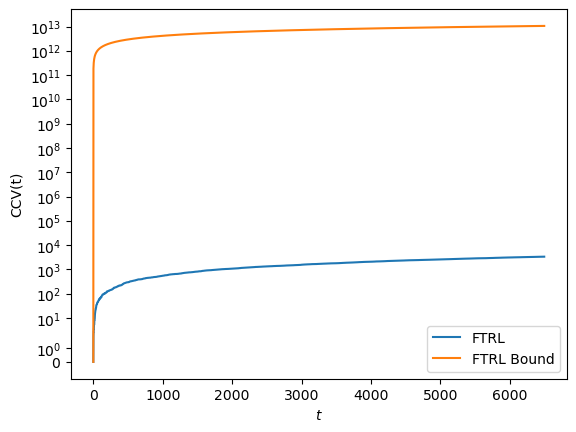

In [13]:
ts = np.linspace(0,T,T+1)
plt.plot(ts, CCV_ftrl, label='FTRL')

plt.plot(ts, FTRL_alg.ccv_bound(ts), label='FTRL Bound')
plt.ylabel('CCV(t)')
plt.xlabel('$t$')
plt.yscale('symlog')
plt.legend()

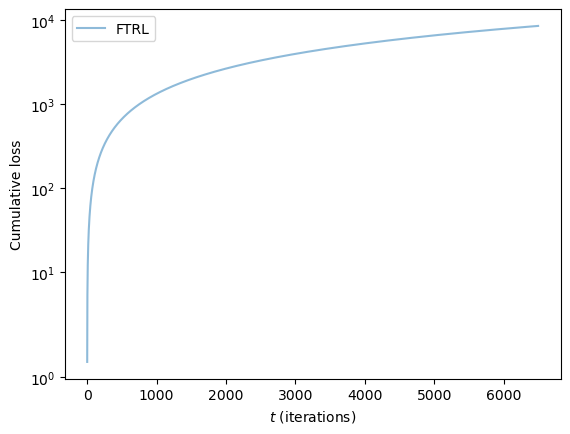

In [14]:
# Plot obtained cost at each round
plot_regret([Cost_ftrl], ['FTRL'])
plt.yscale('symlog')

## Run AdaGrad

In [15]:
#x_0 = np.ones((n+1,))
AdaGrad_alg = adv_AdaGrad(x_0.copy(), T, assumptions_param)
_, Preds = AdaGrad_alg.run(data)

In [16]:
Preds_dict["AdaGrad"] = Preds

In [17]:
# Compute regret and CCV
Cost_sum = 0.0
Cost_AdaGrad = []
CCV_sum = 0.0
CCV_AdaGrad = [0.0]

# Obtain data
features, labels = data

Cost_AdaGrad, CCV_AdaGrad = compute_cost_and_ccv(features, labels, Preds)

/var/folders/bl/yrldgwgd3r3f1mq3t66c5glr0000gn/T/ipykernel_40713/2838070332.py:32: RuntimeWarning: divide by zero encountered in log
  return 6.6 * self.G_temp * self.D * (2 + np.log(t)) * np.sqrt(t)
/var/folders/bl/yrldgwgd3r3f1mq3t66c5glr0000gn/T/ipykernel_40713/2838070332.py:32: RuntimeWarning: invalid value encountered in multiply
  return 6.6 * self.G_temp * self.D * (2 + np.log(t)) * np.sqrt(t)


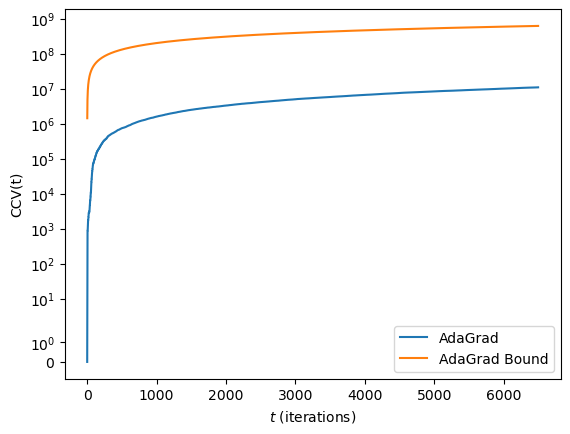

In [18]:
ts = np.linspace(0,T,T+1)
plt.plot(ts, CCV_AdaGrad, label='AdaGrad')

plt.plot(ts, AdaGrad_alg.ccv_bound(ts), label='AdaGrad Bound')
plt.ylabel('CCV(t)')
plt.xlabel('$t$ (iterations)')
plt.yscale('symlog')
plt.legend()

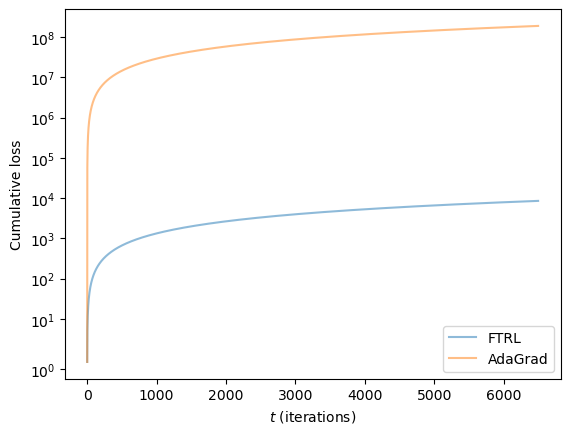

In [19]:
# Plot obtained cost at each round
plot_regret([Cost_ftrl], ['FTRL'])
plot_regret([Cost_AdaGrad], ['AdaGrad'])
plt.yscale('symlog')

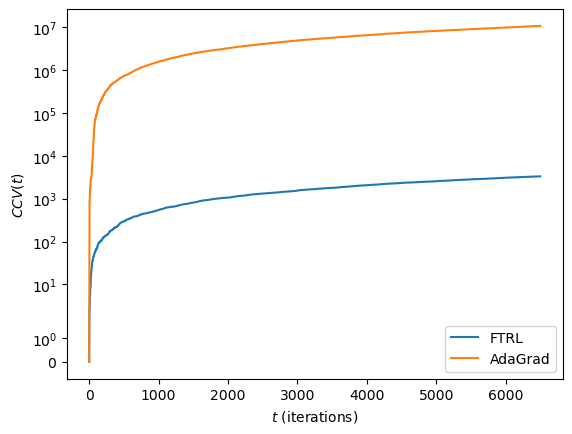

In [20]:
# Plot obtained CCV
plot_ccv([CCV_ftrl, CCV_AdaGrad], 
         ['FTRL', 'AdaGrad'])

## Run OGD

In [21]:
ODG_alg = adv_OGD(x_0.copy(), T, assumptions_param)
_, Preds = ODG_alg.run(data)

In [22]:
Preds_dict["OGD"] = Preds

In [23]:
# Compute regret and CCV
Cost_sum = 0.0
Cost_OGD = []
CCV_sum = 0.0
CCV_OGD = [0.0]

# Obtain data
features, labels = data

Cost_OGD, CCV_OGD = compute_cost_and_ccv(features, labels, Preds)

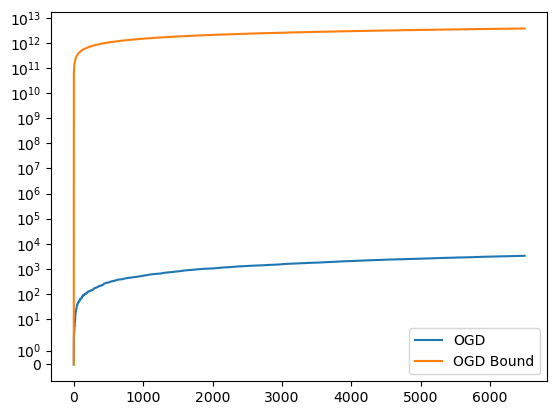

In [24]:
ts = np.linspace(0,T,T+1)
plt.plot(ts, CCV_OGD, label='OGD')

plt.plot(ts, ODG_alg.ccv_bound(ts), label='OGD Bound')
plt.yscale('symlog')
plt.legend()

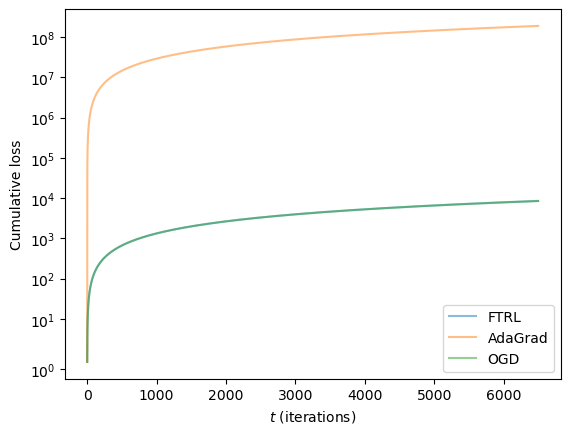

In [25]:
# Plot obtained cost at each round
plot_regret([Cost_ftrl], ['FTRL'])
plot_regret([Cost_AdaGrad], ['AdaGrad'])
plot_regret([Cost_OGD], ['OGD'])
#plt.yscale('symlog')

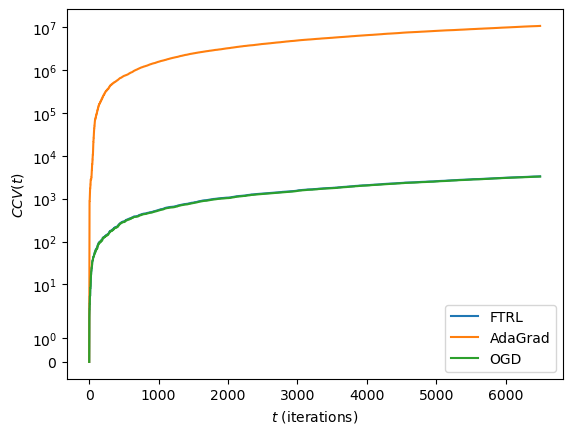

In [26]:
# Plot obtained CCV
plot_ccv([CCV_ftrl, CCV_AdaGrad, CCV_OGD], 
         ['FTRL', 'AdaGrad', 'OGD'])

# Run Multiple Experiments

In [ ]:
S = 100 # Run 100 trials

## Import wine dataset here
# dataset = ...
# features = ...
# labels = ...

n = features.shape[1]
T = features.shape[0]

F = 70 * np.sqrt(n)
G = 70 * np.sqrt(n)
D = 140 * np.sqrt(n)

assumptions_param = (F, G, D)

Cost_dict = {'FTRL': [], 'AdaGrad': [], 'OGD': []}
CCV_dict = {'FTRL': [], 'AdaGrad': [], 'OGD': []}

for _ in tqdm(range(S)):
    
    ## Import wine dataset here
    # dataset = ...
    # np.random.shuffle(dataset)
    # features = ...
    # labels = ...
    
    #Initial guess
    x_0 = np.random.uniform(-1.0, 1.0, size=n+1)
    data = (features, labels)


    FTRL_alg = adv_FTRL(x_0.copy(), T, assumptions_param)
    _, Preds = FTRL_alg.run(data)
    
    Cost_ftrl, CCV_ftrl = compute_cost_and_ccv(features, labels, Preds)
    Cost_dict['FTRL'].append(Cost_ftrl)
    CCV_dict['FTRL'].append(CCV_ftrl)
    
    # Run AdaGrad
    AdaGrad_alg = adv_AdaGrad(x_0.copy(), T, assumptions_param)
    _, Preds = AdaGrad_alg.run(data)
    
    Cost_AdaGrad, CCV_AdaGrad = compute_cost_and_ccv(features, labels, Preds)
    Cost_dict['AdaGrad'].append(Cost_AdaGrad)
    CCV_dict['AdaGrad'].append(CCV_AdaGrad)
    
    # Run Online Gradient Descent
    OGD_alg = adv_OGD(x_0.copy(), T, assumptions_param)
    _, Preds = OGD_alg.run(data)
    
    Cost_OGD, CCV_OGD = compute_cost_and_ccv(features, labels, Preds)
    Cost_dict['OGD'].append(Cost_OGD)
    CCV_dict['OGD'].append(CCV_OGD)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 100/100 [45:03<00:00, 27.04s/it]


In [28]:
Cost_dict['FTRL'] = np.array(Cost_dict['FTRL'])
CCV_dict['FTRL'] = np.array(CCV_dict['FTRL'])

Cost_dict['AdaGrad'] = np.array(Cost_dict['AdaGrad'])
CCV_dict['AdaGrad'] = np.array(CCV_dict['AdaGrad'])

Cost_dict['OGD'] = np.array(Cost_dict['OGD'])
CCV_dict['OGD'] = np.array(CCV_dict['OGD'])

In [29]:
SIZE = 12
plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-1)    # legend fontsize

# Plot mean cumulative cost for the different algorithms

In [30]:
mean_cost_ftrl = np.mean(Cost_dict['FTRL'], axis=0)
std_cost_ftrl = 2 * np.std(Cost_dict['FTRL'], axis=0)

mean_cost_AdaGrad = np.mean(Cost_dict['AdaGrad'], axis=0)
std_cost_AdaGrad = 2 * np.std(Cost_dict['AdaGrad'], axis=0)

mean_cost_ogd = np.mean(Cost_dict['OGD'], axis=0)
std_cost_ogd = 2 * np.std(Cost_dict['OGD'], axis=0)

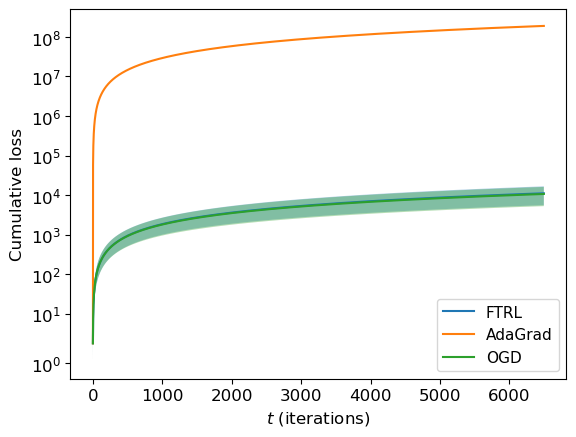

In [31]:
ts = np.linspace(1,T,T)
plt.plot(ts, mean_cost_ftrl, label='FTRL')
plt.fill_between(ts, mean_cost_ftrl-std_cost_ftrl, mean_cost_ftrl+std_cost_ftrl, alpha=0.35)

plt.plot(ts, mean_cost_AdaGrad, label='AdaGrad')
plt.fill_between(ts, mean_cost_AdaGrad-std_cost_AdaGrad, mean_cost_AdaGrad+std_cost_AdaGrad, alpha=0.35)

plt.plot(ts, mean_cost_ogd, label='OGD')
plt.fill_between(ts, mean_cost_ogd-std_cost_ogd, mean_cost_ogd+std_cost_ogd, alpha=0.35)

plt.ylabel('Cumulative loss')
plt.xlabel('$t$ (iterations)')
plt.yscale('symlog')
plt.legend()
plt.savefig('Cost_classification.pdf', format='pdf', bbox_inches='tight')

# Plot mean CCV for the different algorithms

In [32]:
mean_ccv_ftrl = np.mean(CCV_dict['FTRL'], axis=0)
std_ccv_ftrl = 2 * np.std(CCV_dict['FTRL'], axis=0)

mean_ccv_AdaGrad = np.mean(CCV_dict['AdaGrad'], axis=0)
std_ccv_AdaGrad = 2 * np.std(CCV_dict['AdaGrad'], axis=0)

mean_ccv_ogd = np.mean(CCV_dict['OGD'], axis=0)
std_ccv_ogd = 2 * np.std(CCV_dict['OGD'], axis=0)

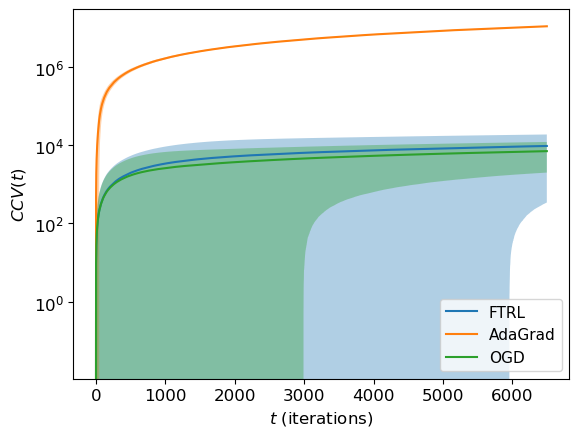

In [33]:
ts = np.linspace(0,T,T+1)
plt.plot(ts, mean_ccv_ftrl, label='FTRL')
plt.fill_between(ts, mean_ccv_ftrl-std_ccv_ftrl, mean_ccv_ftrl+std_ccv_ftrl, alpha=0.35)

plt.plot(ts, mean_ccv_AdaGrad, label='AdaGrad')
plt.fill_between(ts, mean_ccv_AdaGrad-std_ccv_AdaGrad, mean_ccv_AdaGrad+std_ccv_AdaGrad, alpha=0.35)

plt.plot(ts, mean_ccv_ogd, label='OGD')
plt.fill_between(ts, mean_ccv_ogd-std_ccv_ogd, mean_ccv_ogd+std_ccv_ogd, alpha=0.35)

plt.yscale('log')
plt.ylabel('$CCV(t)$')
plt.xlabel('$t$ (iterations)')
plt.legend()

plt.savefig('CCV_classification.pdf', format='pdf', bbox_inches='tight')